In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import jensenshannon as jsd
from figaro.cosmology import CosmologicalParameters
from figaro.load import _find_redshift, load_density
from figaro import plot_settings

## Function Definitions

In [2]:
# Mass distributions
def mean(DL, dMdDL = 30./1000., offset = 5.):
    return DL*dMdDL + offset

def std(DL, dMdDL = 8./1000., offset = 1.):
    return DL*dMdDL + offset

def PLpeak(m, alpha = -2., mmin = 5., mmax = 70., mu = 30., sigma = 4., w = 0.2):
    norm_pl = (1-alpha)/(mmin**(alpha+1) - mmax**(alpha+1))
    pl      = norm_pl * m**alpha
    peak    = np.exp(-0.5*((m-mu)/sigma)**2)/(np.sqrt(2*np.pi)*sigma)
    return w*pl + (1-w)*peak

def evolving_gaussian(m, DL):
    mu = mean(DL)
    sigma = std(DL)
    return np.exp(-0.5*((m-mu)/sigma)**2)/(np.sqrt(2*np.pi)*sigma)

# DL distributions
def DLsq(DL, DLmax = 5000):
    return 3*DL**2/DLmax**3

def gaussian(DL, mu = 1600, sigma = 400):
    return np.exp(-0.5*((DL-mu)/sigma)**2)/(np.sqrt(2*np.pi)*sigma)

In [3]:
def luminosity_distance_to_redshift(distance, H0s):
    return np.array([_find_redshift(CosmologicalParameters(H0/100, 0.315, 0.685, -1, 0), distance) for H0 in H0s])

## Source Frame Distributions
Double Gaussian:
$$p(M, d_L) = p(M|d_L)p(d_L) = \mathrm{evolving\_gaussian}(M, d_L)*\mathrm{gaussian}(d_L)$$

Realistic Model:
$$p(M, d_L) = p(M)p(d_L) = \mathrm{PLpeak}(M)*\mathrm{DLsq}(d_L)$$

In [4]:
m = np.linspace(10,200,1000).reshape(-1,1)
dL = np.linspace(10,5000,100)

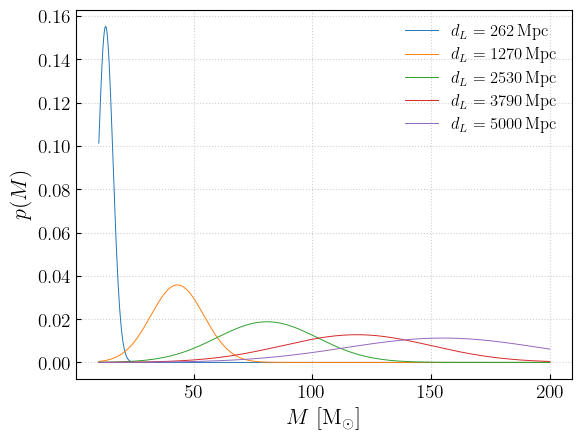

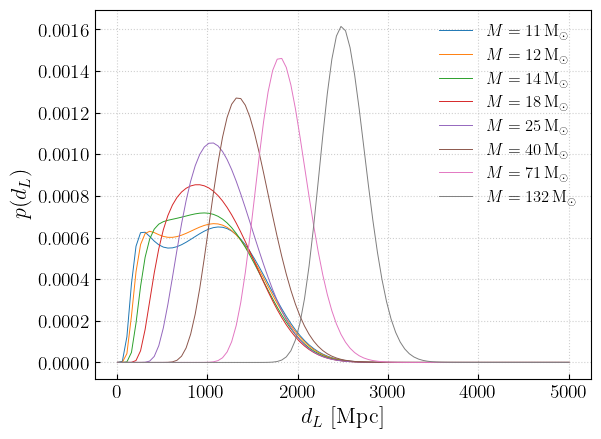

In [5]:
for i in [5,25,50,75,99]:
    prop = np.einsum("ij, j -> ij", evolving_gaussian(m, dL), gaussian(dL))[:,i]
    y = prop/np.sum(prop*(m[1]-m[0]))
    plt.plot(m, y, label = "$d_L = "+str(f'{dL[i]:.0f}')+"\,\mathrm{Mpc}$")
plt.xlabel('$M\ [\mathrm{M}_\odot]$')
plt.ylabel('$p(M)$')
plt.legend()
plt.show()

for i in [5,10,20,40,80,160,320,640]:
    prop = np.einsum("ij, j -> ij", evolving_gaussian(m, dL), gaussian(dL))[i,:]
    y = prop/np.sum(prop*(dL[1]-dL[0]))
    plt.plot(dL, y, label = "$M = "+str(f'{m[i,0]:.0f}')+"\,\mathrm{M}_\odot$")
plt.xlabel('$d_L\ [\mathrm{Mpc}]$')
plt.ylabel('$p(d_L)$')
plt.legend()
plt.show()

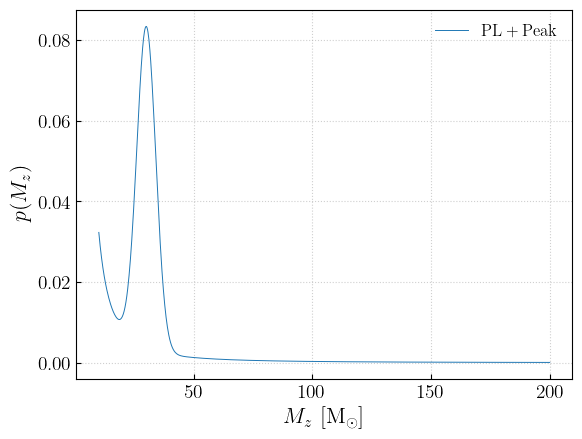

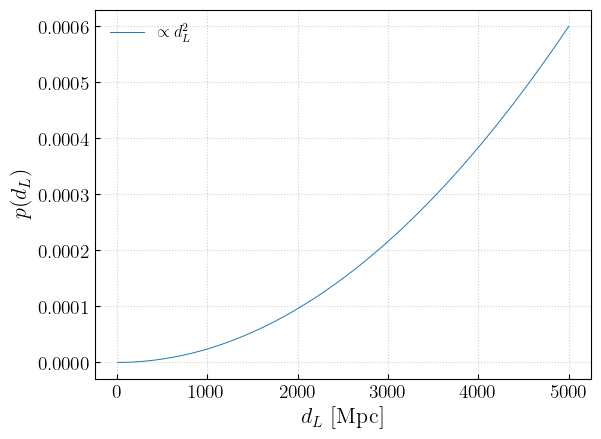

In [6]:
plt.plot(m, PLpeak(m), label = "$\mathrm{PL+Peak}$")
plt.xlabel('$M_z\ [\mathrm{M}_\odot]$')
plt.ylabel('$p(M_z)$')
plt.legend()
plt.show()
plt.plot(dL, DLsq(dL), label = "$\propto d_L^2$")
plt.xlabel('$d_L\ [\mathrm{Mpc}]$')
plt.ylabel('$p(d_L)$')
plt.legend()
plt.show()

## Detector Frame Distributions
Double Gaussian:
$$p(M_z, d_L) = \frac{1}{1+z(d_L, \Omega)}\,\mathrm{evolving\_gaussian}\left(\frac{M_z}{1+z(d_L, \Omega)}, d_L\right)\,\mathrm{gaussian}(d_L)$$

Realistic Model:
$$p(M_z, d_L) = \frac{1}{1+z(d_L, \Omega)}\,\mathrm{PLpeak}\left(\frac{M_z}{1+z(d_L, \Omega)}\right)\,\mathrm{DLsq}(d_L)$$

In [7]:
mz = np.linspace(10,200,1000)
dL = np.linspace(10,5000,100)

H0 = np.linspace(50,100,50)

z = luminosity_distance_to_redshift(dL, H0)

m = np.einsum("i, jk -> ikj", mz, np.reciprocal(1+z))

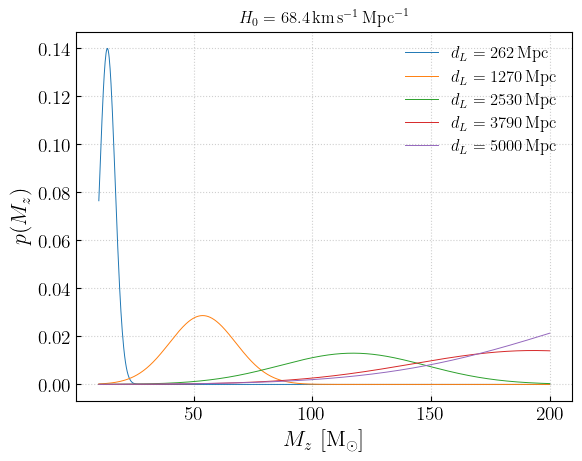

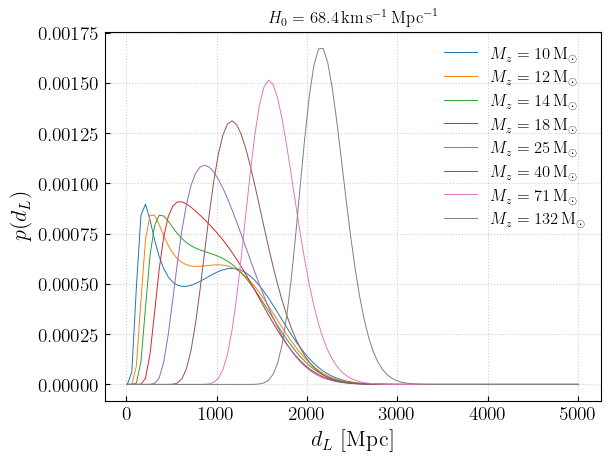

In [8]:
for i in [5,25,50,75,99]:
    prop = np.einsum("ijk, j -> ijk", evolving_gaussian(m, dL.reshape(-1,1)), gaussian(dL))[:,i,18]
    y = prop/np.sum(prop*(mz[1]-mz[0]))
    plt.plot(mz, y, label = "$d_L = "+str(f'{dL[i]:.0f}')+"\,\mathrm{Mpc}$")
plt.title("$H_0 = "+str(f'{H0[18]:.1f}')+"\,\mathrm{km}\,\mathrm{s}^{-1}\,\mathrm{Mpc}^{-1}$")
plt.ylabel('$p(M_z)$')
plt.xlabel('$M_z\ [\mathrm{M}_\odot]$')
plt.legend()
plt.show()

for i in [0,10,20,40,80,160,320,640]:
    prop = np.einsum("ijk, j -> ijk", evolving_gaussian(m, dL.reshape(-1,1)), gaussian(dL))[i,:,18]
    y = prop/np.sum(prop*(dL[1]-dL[0]))
    plt.plot(dL, y, label = "$M_z = "+str(f'{mz[i]:.0f}')+"\,\mathrm{M}_\odot$")
plt.title("$H_0 = "+str(f'{H0[18]:.1f}')+"\,\mathrm{km}\,\mathrm{s}^{-1}\,\mathrm{Mpc}^{-1}$")
plt.ylabel('$p(d_L)$')
plt.xlabel('$d_L\ [\mathrm{Mpc}]$')
plt.legend()
plt.show()

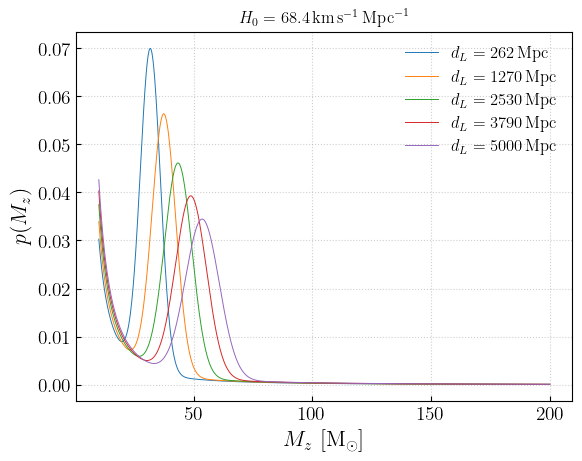

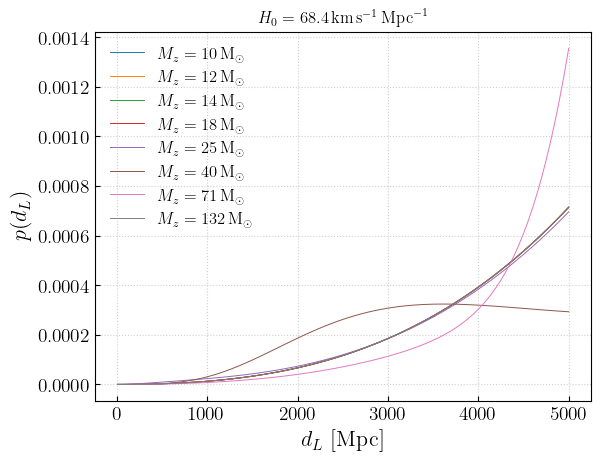

In [9]:
for i in [5,25,50,75,99]:
    prop = np.einsum("ijk, j -> ijk", PLpeak(m), DLsq(dL))[:,i,18]
    y = prop/np.sum(prop*(mz[1]-mz[0]))
    plt.plot(mz, y, label = "$d_L = "+str(f'{dL[i]:.0f}')+"\,\mathrm{Mpc}$")
plt.title("$H_0 = "+str(f'{H0[18]:.1f}')+"\,\mathrm{km}\,\mathrm{s}^{-1}\,\mathrm{Mpc}^{-1}$")
plt.ylabel('$p(M_z)$')
plt.xlabel('$M_z\ [\mathrm{M}_\odot]$')
plt.legend()
plt.show()

for i in [0,10,20,40,80,160,320,640]:
    prop = np.einsum("ijk, j -> ijk", PLpeak(m), DLsq(dL))[i,:,18]
    y = prop/np.sum(prop*(dL[1]-dL[0]))
    plt.plot(dL, y, label = "$M_z = "+str(f'{mz[i]:.0f}')+"\,\mathrm{M}_\odot$")
plt.title("$H_0 = "+str(f'{H0[18]:.1f}')+"\,\mathrm{km}\,\mathrm{s}^{-1}\,\mathrm{Mpc}^{-1}$")
plt.ylabel('$p(d_L)$')
plt.xlabel('$d_L\ [\mathrm{Mpc}]$')
plt.legend()
plt.show()

## Infer $H_0$

In [10]:
mz = np.linspace(10,200,1000)
dL = np.linspace(10,5000,500)

H0 = np.linspace(20,60,500)

z = luminosity_distance_to_redshift(dL, H0)

m = np.einsum("i, jk -> ikj", mz, np.reciprocal(1+z))

In [11]:
p_double_gaussian = np.trapz(np.einsum("ijk, j -> ijk", evolving_gaussian(m, dL.reshape(-1,1)), gaussian(dL)), dL, axis=1)
p_double_gaussian = p_double_gaussian/np.trapz(p_double_gaussian, mz, axis=0)

p_realistic = np.trapz(np.einsum("ijk, j -> ijk", PLpeak(m), DLsq(dL)), dL, axis=1)
p_realistic = p_realistic/np.trapz(p_realistic, mz, axis=0)

### Testing Plots

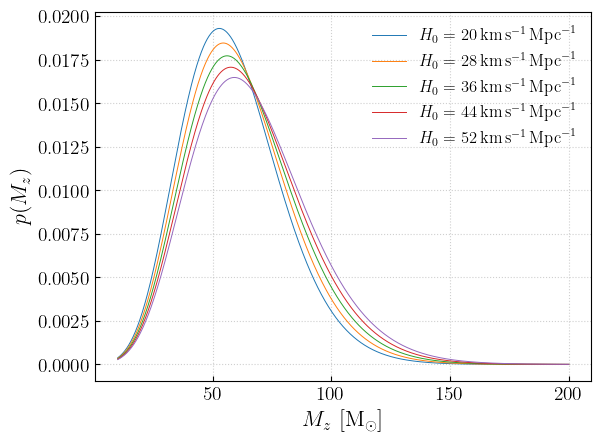

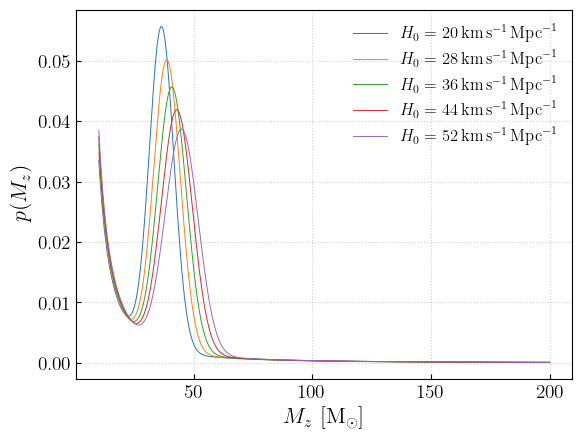

In [12]:
for i in [0,100,200,300,400]:
    prop = p_double_gaussian[:,i]
    plt.plot(mz, prop, label = "$H_0 = "+str(f'{H0[i]:.0f}')+"\,\mathrm{km}\,\mathrm{s}^{-1}\,\mathrm{Mpc}^{-1}$")
plt.ylabel('$p(M_z)$')
plt.xlabel('$M_z\ [\mathrm{M}_\odot]$')
plt.legend()
plt.show()
for i in [0,100,200,300,400]:
    prop = p_realistic[:,i]
    plt.plot(mz, prop, label = "$H_0 = "+str(f'{H0[i]:.0f}')+"\,\mathrm{km}\,\mathrm{s}^{-1}\,\mathrm{Mpc}^{-1}$")
plt.xlabel('$M_z\ [\mathrm{M}_\odot]$')
plt.ylabel('$p(M_z)$')
plt.legend()
plt.show()

### Estimating with Median Distribution Only

In [13]:
double_gaussian_figaro = np.loadtxt("./double_gaussian/prob_density.txt")
realistic_figaro = np.loadtxt("./realistic/prob_density.txt")

#### Squared Distance

In [14]:
double_gaussian_error = np.sum(np.square(p_double_gaussian - np.full((len(H0), len(mz)), np.interp(mz, double_gaussian_figaro[:,0], double_gaussian_figaro[:,1])).T), axis=0)
realistic_error = np.sum(np.square(p_realistic - np.full((len(H0), len(mz)), np.interp(mz, realistic_figaro[:,0], realistic_figaro[:,1])).T), axis=0)

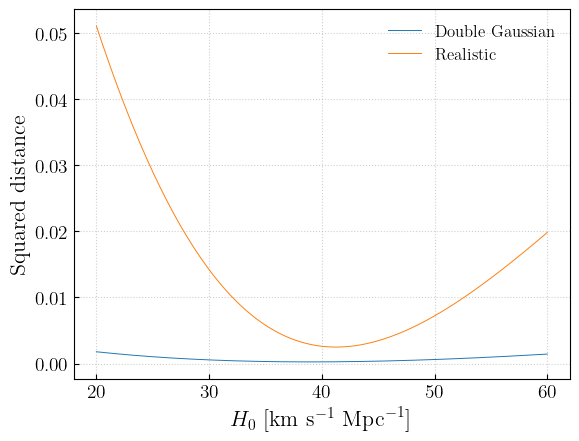

In [15]:
plt.plot(H0, double_gaussian_error, label = "$\mathrm{Double\ Gaussian}$")
plt.plot(H0, realistic_error, label = "$\mathrm{Realistic}$")
plt.xlabel('$H_0\ [\mathrm{km}\ \mathrm{s}^{-1}\ \mathrm{Mpc}^{-1}]$')
plt.ylabel('$\mathrm{Squared\ distance}$')
plt.legend()
plt.show()

In [16]:
H0_double_gaussian = H0[np.argmin(double_gaussian_error)]
H0_realistic = H0[np.argmin(realistic_error)]

In [17]:
H0_double_gaussian, H0_realistic

(38.99799599198397, 41.24248496993988)

#### Jensen-Shannon Distance

In [18]:
double_gaussian_jsd = jsd(p_double_gaussian, np.full((len(H0), len(mz)), np.interp(mz, double_gaussian_figaro[:,0], double_gaussian_figaro[:,1])).T)
realistic_jsd = jsd(p_realistic, np.full((len(H0), len(mz)), np.interp(mz, realistic_figaro[:,0], realistic_figaro[:,1])).T)

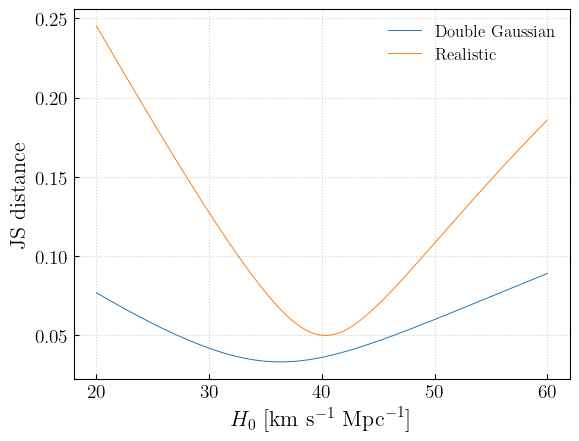

In [19]:
plt.plot(H0, double_gaussian_jsd, label = "$\mathrm{Double\ Gaussian}$")
plt.plot(H0, realistic_jsd, label = "$\mathrm{Realistic}$")
plt.xlabel('$H_0\ [\mathrm{km}\ \mathrm{s}^{-1}\ \mathrm{Mpc}^{-1}]$')
plt.ylabel('$\mathrm{JS\ distance}$')
plt.legend()
plt.show()

In [20]:
H0_double_gaussian = H0[np.argmin(double_gaussian_jsd)]
H0_realistic = H0[np.argmin(realistic_jsd)]

In [21]:
H0_double_gaussian, H0_realistic

(36.35270541082164, 40.360721442885776)

### Estimating $H_0$ with All Distributions (Jensen-Shannon Distance)

In [22]:
double_gaussian_figaro = load_density("./double_gaussian/density.pkl")
realistic_figaro = load_density("./realistic/density.pkl")

In [23]:
double_gaussian_figaro = np.array([double_gaussian_figaro[i].pdf(mz) for i in range(len(double_gaussian_figaro))])
realistic_figaro = np.array([realistic_figaro[i].pdf(mz) for i in range(len(realistic_figaro))])

In [24]:
double_gaussian_jsd = np.array([jsd(p_double_gaussian, np.full((len(H0), len(mz)), double_gaussian_figaro[i]).T) for i in range(len(double_gaussian_figaro))])
realistic_jsd = np.array([jsd(p_realistic, np.full((len(H0), len(mz)), realistic_figaro[i]).T) for i in range(len(realistic_figaro))])

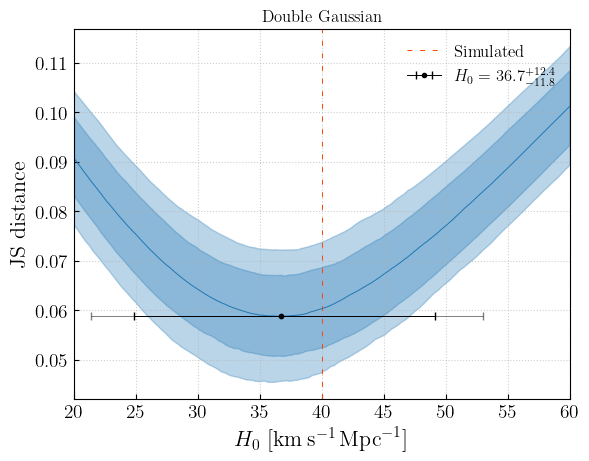

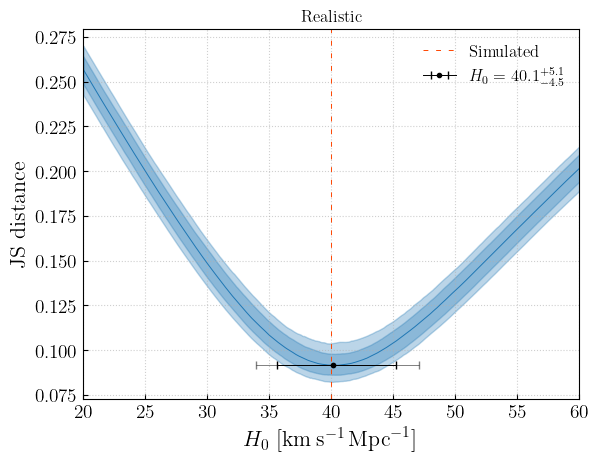

In [43]:
percs_double_gaussian = np.percentile(double_gaussian_jsd, [5, 16, 50, 84, 95], axis=0)
plt.axvline(40, lw = 0.7, ls = '--', dashes=(5, 8), c = 'orangered', label = '$\\mathrm{Simulated}$')

plt.fill_between(H0, percs_double_gaussian[0], percs_double_gaussian[-1], alpha=0.3, color='C0')
plt.fill_between(H0, percs_double_gaussian[1], percs_double_gaussian[-2], alpha=0.3, color='C0')
plt.plot(H0, percs_double_gaussian[2], color='C0')

# Point Estimate
H0_double_gaussian = H0[np.argmin(percs_double_gaussian[2])]

# 90% CI
jsd_upper_bound = percs_double_gaussian[4].min()
jsd_upper_bound_index = np.argmin(percs_double_gaussian[4])
bool_array = percs_double_gaussian[0]>jsd_upper_bound
lower_bound = np.where((bool_array)[1:jsd_upper_bound_index])[0][-1]
upper_bound = np.where((bool_array)[jsd_upper_bound_index:])[0][0] + jsd_upper_bound_index
plt.errorbar(H0_double_gaussian, percs_double_gaussian[2].min(), xerr=[[H0_double_gaussian-H0[lower_bound]], [H0[upper_bound]-H0_double_gaussian]],
             color='k', capsize=3, marker='o', markersize=3, alpha = 0.5)
# 68% CI
jsd_upper_bound = percs_double_gaussian[3].min()
jsd_upper_bound_index = np.argmin(percs_double_gaussian[3])
bool_array = percs_double_gaussian[1]>jsd_upper_bound
lower_bound = np.where((bool_array)[1:jsd_upper_bound_index])[0][-2]
upper_bound = np.where((bool_array)[jsd_upper_bound_index:])[0][1] + jsd_upper_bound_index
plt.errorbar(H0_double_gaussian, percs_double_gaussian[2].min(), xerr=[[H0_double_gaussian-H0[lower_bound]], [H0[upper_bound]-H0_double_gaussian]],
             color='k', capsize=3, marker='o', markersize=3,
             label = '$H_0 = '+str(f'{H0_double_gaussian:.1f}')+'^{+'+str(f'{H0[upper_bound]-H0_double_gaussian:.1f}')+'}_{-'+str(f'{H0_double_gaussian-H0[lower_bound]:.1f}')+'}$')

plt.xlim(20,60)
plt.xlabel('$H_0\ [\mathrm{km}\,\mathrm{s}^{-1}\,\mathrm{Mpc}^{-1}]$')
plt.ylabel('$\mathrm{JS\ distance}$')
plt.title('$\mathrm{Double\ Gaussian}$')
plt.legend(loc = 0)
plt.show()


percs_realistic = np.percentile(realistic_jsd, [5, 16, 50, 84, 95], axis=0)
plt.axvline(40, lw = 0.7, ls = '--', dashes=(5, 8), c = 'orangered', label = '$\\mathrm{Simulated}$')
plt.fill_between(H0, percs_realistic[0], percs_realistic[-1], alpha=0.3, color='C0')
plt.fill_between(H0, percs_realistic[1], percs_realistic[-2], alpha=0.3, color='C0')
plt.plot(H0, percs_realistic[2], color='C0')

# Point Estimate
H0_realistic = H0[np.argmin(percs_realistic[2])]

# 90% CI
jsd_upper_bound = percs_realistic[4].min()
jsd_upper_bound_index = np.argmin(percs_realistic[4])
bool_array = percs_realistic[0]>jsd_upper_bound
lower_bound = np.where((bool_array)[0:jsd_upper_bound_index])[0][-1]
upper_bound = np.where((bool_array)[jsd_upper_bound_index:])[0][0] + jsd_upper_bound_index
plt.errorbar(H0_realistic, percs_realistic[2].min(), xerr=[[H0_realistic-H0[lower_bound]], [H0[upper_bound]-H0_realistic]],
             color='k', capsize=3, marker='o', markersize=3, alpha = 0.5)
# 68% CI
jsd_upper_bound = percs_realistic[3].min()
jsd_upper_bound_index = np.argmin(percs_realistic[3])
bool_array = percs_realistic[1]>jsd_upper_bound
lower_bound = np.where((bool_array)[0:jsd_upper_bound_index])[0][-2]
upper_bound = np.where((bool_array)[jsd_upper_bound_index:])[0][1] + jsd_upper_bound_index
plt.errorbar(H0_realistic, percs_realistic[2].min(), xerr=[[H0_realistic-H0[lower_bound]], [H0[upper_bound]-H0_realistic]],
             color='k', capsize=3, marker='o', markersize=3,
             label = '$H_0 = '+str(f'{H0_realistic:.1f}')+'^{+'+str(f'{H0[upper_bound]-H0_realistic:.1f}')+'}_{-'+str(f'{H0_realistic-H0[lower_bound]:.1f}')+'}$')

plt.xlim(20,60)
plt.xlabel('$H_0\ [\mathrm{km}\,\mathrm{s}^{-1}\,\mathrm{Mpc}^{-1}]$')
plt.ylabel('$\mathrm{JS\ distance}$')
plt.title('$\mathrm{Realistic}$')
plt.legend(loc = 0)
plt.show()

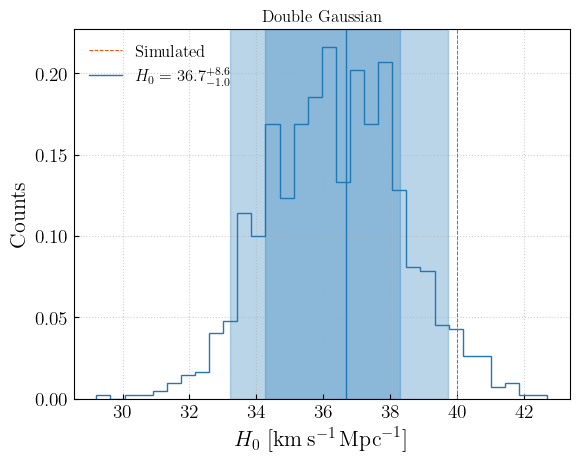

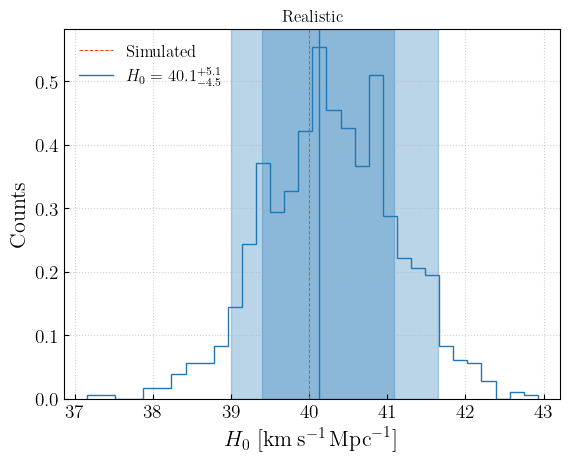

In [42]:
H0_sample_double_gaussian = H0[np.argmin(double_gaussian_jsd, axis=1)]
percs_double_gaussian = np.percentile(H0_sample_double_gaussian, [5, 16, 50, 84, 95])
plt.hist(H0_sample_double_gaussian, density = True, histtype = 'step')
plt.axvline(40, lw = 0.7, ls = '--', c = 'orangered', label = '$\\mathrm{Simulated}$')
plt.axvline(H0_double_gaussian, c = 'C0', lw=1,
            label = '$H_0 = '+str(f'{H0_double_gaussian:.1f}')+'^{+'+str(f'{H0[upper_bound]-H0_double_gaussian:.1f}')+'}_{-'+str(f'{H0_double_gaussian-H0[lower_bound]:.1f}')+'}$')
plt.axvspan(percs_double_gaussian[1], percs_double_gaussian[3], alpha=0.3, color='C0')
plt.axvspan(percs_double_gaussian[0], percs_double_gaussian[4], alpha=0.3, color='C0')
plt.xlabel('$H_0\ [\mathrm{km}\,\mathrm{s}^{-1}\,\mathrm{Mpc}^{-1}]$')
plt.ylabel('$\mathrm{Counts}$')
plt.title('$\mathrm{Double\ Gaussian}$')
plt.legend(loc = 0)
plt.show()

H0_sample_realistic = H0[np.argmin(realistic_jsd, axis=1)]
percs_realistic = np.percentile(H0_sample_realistic, [5, 16, 50, 84, 95])
plt.hist(H0_sample_realistic, density = True, histtype = 'step')
plt.axvline(40, lw = 0.7, ls = '--', c = 'orangered', label = '$\\mathrm{Simulated}$')
plt.axvline(H0_realistic, c = 'C0', lw=1,
            label = '$H_0 = '+str(f'{H0_realistic:.1f}')+'^{+'+str(f'{H0[upper_bound]-H0_realistic:.1f}')+'}_{-'+str(f'{H0_realistic-H0[lower_bound]:.1f}')+'}$')
plt.axvspan(percs_realistic[1], percs_realistic[3], alpha=0.3, color='C0')
plt.axvspan(percs_realistic[0], percs_realistic[4], alpha=0.3, color='C0')
plt.xlabel('$H_0\ [\mathrm{km}\,\mathrm{s}^{-1}\,\mathrm{Mpc}^{-1}]$')
plt.ylabel('$\mathrm{Counts}$')
plt.title('$\mathrm{Realistic}$')
plt.legend(loc = 0)
plt.show()

In [41]:
print(f"Double Gaussian: "+str(np.sum(H0_sample_double_gaussian<=40)/len(H0_sample_double_gaussian)))
print(f"Realistic: "+str(np.sum(H0_sample_realistic<=40)/len(H0_sample_realistic)))

Double Gaussian: 0.961
Realistic: 0.375
